In [1]:
from IPython.display import HTML, clear_output, YouTubeVideo, IFrame
import json
import time
import pandas as pd
import os
from supabase import create_client

In [36]:
# Connect to database
url = os.environ.get("SUPABASE_URL")
key = os.environ.get("SUPABASE_KEY")
email = os.environ.get("EMAIL")
password = os.environ.get("PASSWORD")
client = create_client(url, key)
user = client.auth.sign_in(email=email, password=password)

In [49]:
clarity_list = ['easy', 'medium', 'hard', 'bad']

### Instructions

1. Connect to var_data table in supabase and filter out all video clips that DO NOT have a 'clarity_level' of 'none'

2. If clarity_level is none, then play video with embedded video player

3. Create system that allows you to:
    - change the time_start and time_end of the video clip
    - input clarity_level

Note: These changes MUST be reflected in the var_data table in supabase

In [43]:
# create list of matching labels where clarity_level is none
clips = list(client.table('var_data').select('clarity_level', 'id', 'time_start', 'time_end', 'label').eq('clarity_level', 'none').eq('label', 'striking').execute())[0][1]
clips

[{'clarity_level': 'none',
  'id': '69aE7uGVbuI1',
  'time_start': 7,
  'time_end': 9,
  'label': 'striking'},
 {'clarity_level': 'none',
  'id': '9M4rA3WVzTg1',
  'time_start': 77,
  'time_end': 81,
  'label': 'striking'},
 {'clarity_level': 'none',
  'id': 'w3gjPubsNtI82',
  'time_start': 999,
  'time_end': 1000,
  'label': 'striking'},
 {'clarity_level': 'none',
  'id': 'w3gjPubsNtI84',
  'time_start': 1023,
  'time_end': 1024,
  'label': 'striking'},
 {'clarity_level': 'none',
  'id': 'w3gjPubsNtI85',
  'time_start': 1047,
  'time_end': 1048,
  'label': 'striking'},
 {'clarity_level': 'none',
  'id': 'w3gjPubsNtI87',
  'time_start': 1106,
  'time_end': 1107,
  'label': 'striking'},
 {'clarity_level': 'none',
  'id': 'w3gjPubsNtI88',
  'time_start': 1125,
  'time_end': 1126,
  'label': 'striking'},
 {'clarity_level': 'none',
  'id': 'w3gjPubsNtI91',
  'time_start': 1132,
  'time_end': 1137,
  'label': 'striking'},
 {'clarity_level': 'none',
  'id': 'w3gjPubsNtI92',
  'time_start': 1

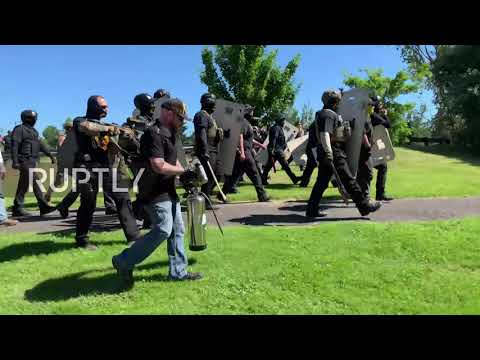

In [48]:
break_out = False

while True:

    for index, clip in enumerate(clips):

        adjusting_annot = True
        untagged = True

        id = clip['id']
        start = clip['time_start']
        end = clip['time_end']
        #url = f'https://www.youtube.com/watch?v={id}'

        while adjusting_annot == True:

            vid = YouTubeVideo(id[0:11], start=start, end=end, allow_autoplay=True)
            display(vid)

            data = input("r=restartvid, (s or e)(num)=change start or end time,xxx=badegg(delete), xxxr=reversedelete, cl (e,m,h)=claritylevel, exit=exit")

            # restart video
            if data == 'r':
                continue

            # change start and/or end time
            if data == 's':
                time_stamp = input('enter new timestamp (2:23, 2:34): ')

                # convert time to total seconds
                user_segment = user_segment.replace(",", "")
                time_list = user_segment.split(' ')
                time_list = [item.split(":") for item in time_list]
                time_list[0][0] = float(time_list[0][0]) * 60
                time_list[1][0] = float(time_list[1][0]) * 60
                time_list[0][1] = float(time_list[0][1])
                time_list[1][1] = float(time_list[1][1])
                time_start = time_list[0][0] + float(time_list[0][1])
                time_end = time_list[1][0] + float(time_list[1][1])

                # insert new data into var_data
                client.table('var_data').update({'time_start': time_start, 'time_end': time_end}).eq('id', id).execute()

            # update clarity_level
            if data == 'cl':
                clarity = input('enter clarity_level (easy, medium, hard or bad): ')

                # insert new clarity_level to var_data
                if clarity in clarity_list:
                    client.table('var_data').update({'clarity_level': clarity}).eq('id', id)
                    untagged = False
                else:
                    print('invalid input, try again')
                    continue

            
            # go to next video
            if data == 'n':
                if untagged == True:
                    print('no tag on video')
                    continue
                else:
                    adjusting_annot = False    

            
            # go to previous video
            if data == 'p':
                index -= 1
                adjusting_annot = False

            # 
            if data == 'exit':
                break_out = True
                adjusting_annot = False



            continue

    break
